## Interacions
Estraggo le interacions dal dataset dei commenti 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_comments.csv',encoding='ISO-8859-1')
post_count = data.groupby('post_id')['from_id'].nunique().reset_index(name='post_size')
post_from_count = data.groupby(['post_id', 'from_id']).size().reset_index(name='interaction_len')
joined_df = pd.merge(post_count, post_from_count, on='post_id', how='inner')
joined_df[['post_size','interaction_len']].to_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_interactions.csv')

## Outreach for each post

I successivi blocchi di codice consentono di fare un confronto tra la len dell'interazione e la size dell'outreach di una pagina misurata come Lurkers in quel momento.

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

In [2]:
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv',usecols=['created_time', 'page_id', 'post_id'],encoding='ISO-8859-1')
likes = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_likes.csv', usecols=['from_id', 'post_id'], encoding='ISO-8859-1')
np.mean(posts['post_id'].isin(likes['post_id'])) # Solo del 66% dei post abbiamo i like? questa cosa è strana e da ricontrollare.

Salvo per ciascuna pagine la serie storica dei Lurkers, ovvero il numero di utenti univoci che ha lasciato like a un qualsiasi post della pagina.

In [8]:
import pandas as pd
from tqdm import tqdm

folder_path = '/home/jacoponudo/Documents/Size_effects/DATA/'
dataframes = []

# Itera su ogni ID di pagina unico
for page_id in tqdm(posts['page_id'].unique()):
    page_posts = posts[posts['page_id'] == page_id]
    page_likes = likes[likes['post_id'].isin(page_posts['post_id'].unique())]

    # Unisci i dati dei post con i dati dei like
    complete_page_likes = pd.merge(page_posts, page_likes, on='post_id', how='right')
    complete_page_likes['created_time'] = pd.to_datetime(complete_page_likes['created_time'])
    complete_page_likes.set_index('created_time', inplace=True)

    # Calcola il numero di utenti unici settimanali
    weekly_unique_users = complete_page_likes['from_id'].resample('W').nunique()
    monthly_moving_avg = weekly_unique_users.rolling(window=8).mean()
    
    # Crea il DataFrame per la media mobile mensile
    monthly_avg_df = pd.DataFrame({
        'Date': monthly_moving_avg.index,
        'Monthly Moving Average': monthly_moving_avg.values
    }).dropna() 
    
    # Aggiungi l'ID della pagina
    monthly_avg_df.insert(2, 'page_id', page_id)
    dataframes.append(monthly_avg_df)

# Concatenazione di tutti i DataFrame in un unico DataFrame outreach
outreachs = pd.concat(dataframes, ignore_index=True)

# Salva il file completo di outreach
output_file = f'{folder_path}/outreach_sample.csv'
outreachs.to_csv(output_file, index=False)

print(f"File salvato in: {output_file}")



100%|██████████| 117/117 [08:18<00:00,  4.26s/it]

File salvato in: /home/jacoponudo/Documents/Size_effects/DATA//outreach_complete.csv


Puliamo la ram da tutti i file in memoria.

In [12]:
import gc
def clear_all():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()

# Pulisci la RAM da tutte le variabili
clear_all()

Per ogni interazione, calcolo quanto dura (interaction len) e dove avviene (page_id), e qual'era il valore di Luckers sulla pagina su cui avviene in quel momento.

In [13]:
comments = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_comments.csv',encoding='ISO-8859-1',usecols=['from_id', 'post_id'])
interactions = comments.groupby(['from_id', 'post_id']).size().reset_index(name='interaction_len')
del comments
gc.collect()

0

Interpolazione dell'outreach di ogni post.

In [14]:
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv',usecols=['created_time', 'page_id', 'post_id'],encoding='ISO-8859-1')
outreach_values = []
for idx, post in tqdm(posts.iterrows(), total=posts.shape[0]):
    page_id = post['page_id']
    outreach = outreachs[outreachs['page_id'] == int(page_id)].copy()
    target_date = pd.to_datetime(post['created_time'])
    previous_date_row = outreach[outreach['Date'] < target_date]
    if not previous_date_row.empty:
        monthly_moving_avg = previous_date_row.loc[previous_date_row['Date'].idxmax()]['Monthly Moving Average']
    else:
        monthly_moving_avg = None
    outreach_values.append(monthly_moving_avg)
posts['outreach'] = outreach_values


100%|██████████| 1482309/1482309 [24:10<00:00, 1021.79it/s]


In [41]:
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions['interaction_len'] < 2)
posts_selected = posts[['post_id', 'outreach','created_time','page_id']]

,created_time,post_id,page_id,outreach,year
6725,2014-12-31 23:53:44+00:00,157466287640348_763942013659436,157466287640348,663.125,2014
6726,2014-12-31 23:52:40+00:00,157466287640348_763941736992797,157466287640348,663.125,2014
6727,2014-12-31 15:01:32+00:00,157466287640348_763754383678199,157466287640348,663.125,2014
6728,2014-12-31 08:36:28+00:00,157466287640348_763507197036251,157466287640348,663.125,2014
6729,2014-12-31 08:32:14+00:00,157466287640348_763506033703034,157466287640348,663.125,2014
...,...,...,...,...,...
1472008,2014-01-03 20:08:20+00:00,160111214030709_654842377890921,160111214030709,2.000,2014
1472009,2014-01-03 18:00:41+00:00,160111214030709_654795571228935,160111214030709,2.000,2014
1472010,2014-01-03 18:00:19+00:00,160111214030709_654795301228962,160111214030709,2.000,2014
1472011,2014-01-03 17:31:06+00:00,160111214030709_654783137896845,160111214030709,2.000,2014


## Alpha vs Size

In [16]:
import pandas as pd
posts['created_time'] = pd.to_datetime(posts['created_time'])
posts['year'] = posts['created_time'].dt.year
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions_selected['interaction_len'] < 2).astype(int)
posts_selected = posts[['post_id', 'outreach', 'created_time', 'year']]
merged = pd.merge(posts_selected, interactions_selected, on='post_id', how='left')
alpha_mean_per_year = merged.groupby('year')['alpha'].mean().reset_index()
print(alpha_mean_per_year)


   year     alpha
0  2009  0.982904
1  2010  0.909769
2  2011  0.904988
3  2012  0.901978
4  2013  0.926843
5  2014  0.378511
6  2015  0.960698
7  2016  1.000000


## Interaction len VS outreach

<Figure size 1200x600 with 0 Axes>

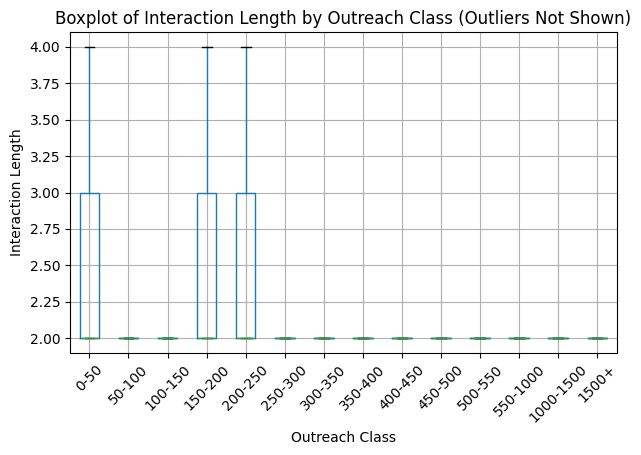

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Merge data
merged_df = pd.merge(interactions_selected[interactions_selected['interaction_len'] >= 2], posts_selected, on='post_id', how='inner')
merged_df = merged_df[merged_df['outreach'] < 3000]

# Prepare data
x = merged_df['outreach']
y = merged_df['interaction_len']

# Define the bin edges and labels
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 1000, 1500, np.inf]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450', '450-500', '500-550', '550-1000', '1000-1500', '1500+']

# Cut x into classes
merged_df['outreach_class'] = pd.cut(x, bins=bins, labels=labels, right=False)

# Create boxplot without showing outliers
plt.figure(figsize=(12, 6))
merged_df.boxplot(column='interaction_len', by='outreach_class', showfliers=False, grid=False)

# Customize the plot
plt.title('Boxplot of Interaction Length by Outreach Class (Outliers Not Shown)')
plt.suptitle('')  # Remove the default title added by boxplot
plt.xlabel('Outreach Class')
plt.ylabel('Interaction Length')
# plt.yscale('log')  # Uncomment to set y-axis to log scale
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout
plt.show()


## Alpha vs Page

In [48]:
import pandas as pd

# Seleziona le colonne desiderate da interactions e crea la colonna 'alpha'
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions['interaction_len'] ==1)

# Seleziona le colonne desiderate da posts
posts_selected = posts[['post_id', 'outreach', 'created_time', 'page_id']]

# Unisci i due DataFrame
merged_df = pd.merge(interactions_selected, posts_selected, on='post_id', how='inner')

# Raggruppa per 'alpha' e 'page_id' e calcola la media di 'interaction_len'
result = merged_df.groupby([ 'page_id'])['alpha'].mean().reset_index()

# Visualizza il risultato
print(result)



              page_id     alpha
0          5953112932  1.000000
1          6250307292  0.958421
2          6533373917  0.966717
3          7130088677  0.972269
4          7155422274  0.965182
..                ...       ...
109   527351247377965  0.971910
110   552321618120006  1.000000
111   554092937948891  1.000000
112   842786335748518  0.933333
113  1512926715599838  0.967302

[114 rows x 2 columns]


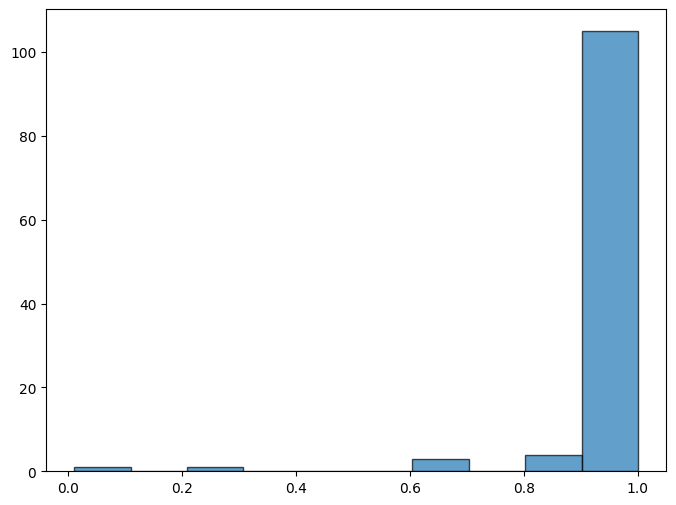

In [51]:
import matplotlib.pyplot as plt

# Crea l'istogramma della distribuzione di alpha
plt.figure(figsize=(8, 6))
plt.hist(result['alpha'], edgecolor='black', alpha=0.7)

# Aggiungi titolo e etichette
plt.show()


## Plot Alpha VS outreach

/tmp/ipykernel_68449/1897349455.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()


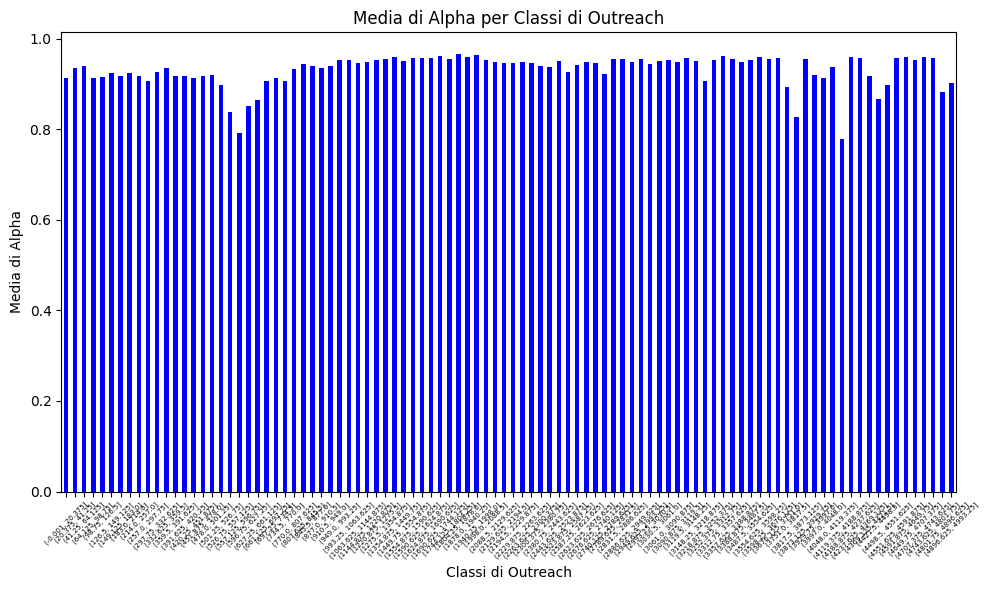

In [58]:
merged_df = pd.merge(interactions_selected, posts_selected, on='post_id', how='inner')
merged_df=merged_df[merged_df['outreach']<5000]
merged_df['outreach_class'] = pd.qcut(merged_df['outreach'], q=100, duplicates='drop')
outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()
plt.figure(figsize=(10, 6))
outreach_alpha_mean.plot(kind='bar', color='blue')
plt.title('Media di Alpha per Classi di Outreach')
plt.xlabel('Classi di Outreach')
plt.ylabel('Media di Alpha')
plt.xticks(rotation=45,fontsize=5)
plt.tight_layout()
plt.show()


## Fare il confronto per il comportamento degli utenti per una stessa pagina al crescere della pagina